In [1]:
import os, numpy as np
import histogram.hdf as hh
import mcvine, mcvine.components, mcvine.run_script

from matplotlib import pyplot as plt
%matplotlib notebook

In [2]:
from mcni.utils import conversion as C

In [3]:
workdir = os.path.expanduser("/SNS/users/lj7/dv/sns-chops/resolution/ARCS/whitebeam/")
!mkdir -p {workdir}
%cd {workdir}

/SNS/users/lj7/dv/sns-chops/resolution/ARCS/whitebeam


# Test non-pyre


In [4]:
import mcvine, mcvine.components as mcomps

In [66]:
%%file test_E_mon.py

import numpy as np
import mcvine, mcvine.components as mcomps

def instrument():
    instrument = mcvine.instrument()

    src = mcomps.sources.Source_simple(name='player', dist=1., E0=500, dE=200, gauss=0)
    instrument.append(src, position=(0.,0,0), orientation=(0,0,0))
    
    save = mcomps.monitors.NeutronToStorage(name='save', path='neutrons')
    instrument.append(save, position=(0, 0, 1.), orientation=(0,0,0))
    
    E_det = mcomps.monitors.E_monitor(
        name='E_det', nchan=2,
        xmin=-.05, xmax=.05, ymin=-.025, ymax=.05,
        Emin=0, Emax=10000.,
        filename='E.dat', )
    instrument.append(E_det, position=(0.0, 0.0, 1.001), orientation=(0, 0, 0))
    return instrument

Overwriting test_E_mon.py


In [67]:
rm -rf work-test_E_mon/

In [68]:
%%time
ncount = "1e6"
!python -m "mcvine.run_script" test_E_mon.py \
    --workdir work-test_E_mon --overwrite_datafiles \
    --ncount {int(float(ncount))}  --mpi-mode server --nodes 1 \
    --run-pps

Source_simple: initialized.
E_monitor: initialized. E window=0,10000, x window=-0.1,0.1, y window = -0.1, 0.1
finalize component "player"
<E> : 500.105 meV , E-width : 115.427 meV 
E_monitor: saved data to file 'E.dat'.
E_monitor: finalized.
finalize component "E_det"
CPU times: user 177 ms, sys: 58.8 ms, total: 236 ms
Wall time: 11.1 s


<IPython.core.display.Javascript object>


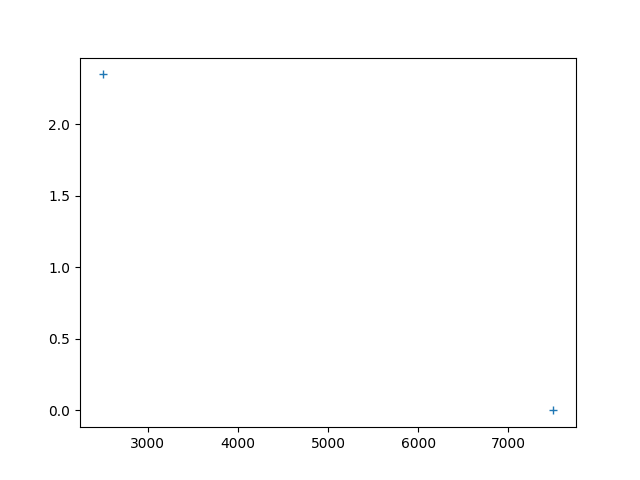

In [69]:
IE = hh.load('./work-test_E_mon/E.h5')
plt.figure()
plt.plot(IE.energy, IE.I, '+')

In [70]:
IE.I.sum()

2.3503172914380293

In [107]:
IE1 = hh.load('./work-test_E_mon/rank0-step0/E.h5')
IE1.I.sum()

156687.72165198761

In [84]:
IE1 = hh.load('./work-test_E_mon/rank0-step4/E.h5')
IE1.I.sum()

783439.38144460786

In [73]:
cat ./work-test_E_mon/rank0-step0/number_of_mc_samples

200000

In [74]:
156687.72165198761/200000

0.783438608259938

In [75]:
from mcni.components import HistogramBasedMonitorMixin

In [77]:
summedHist, N = HistogramBasedMonitorMixin.hist_mcs_sum('./work-test_E_mon/', 'E.h5')

In [78]:
summedHist.I.sum()

2350317.2914380291

In [79]:
N

1000000.0

In [80]:
ls -tl work-test_E_mon/

total 52377
-rw-r--r-- 1 lj7 users 80001100 Sep 14 10:48 neutrons
-rw-r--r-- 1 lj7 users    16408 Sep 14 10:48 E.h5
drwxr-xr-x 2 lj7 users        4 Sep 14 10:48 post-processing-scripts/
drwxr-xr-x 2 lj7 users        5 Sep 14 10:48 rank0-step4/
drwxr-xr-x 2 lj7 users        5 Sep 14 10:48 rank0-step3/
drwxr-xr-x 2 lj7 users        5 Sep 14 10:48 rank0-step2/
drwxr-xr-x 2 lj7 users        5 Sep 14 10:48 rank0-step1/
drwxr-xr-x 2 lj7 users        5 Sep 14 10:48 rank0-step0/


In [54]:
import mcni.neutron_storage as mns

In [55]:
neutrons = mns.readneutrons_asnpyarr('./work-test_E_mon/neutrons')

In [56]:
neutrons[:, -1].sum()/neutrons.shape[0]

0.7834404880868503

In [57]:
p = neutrons[:, -1]

In [58]:
p.mean()

0.7834404880868503

In [59]:
p[p<1e-3]

array([], dtype=float64)

In [60]:
n1 = mns.readneutrons_asnpyarr('./work-test_E_mon/rank0-step0/neutrons')

In [61]:
n1[:, -1]

array([ 0.78172294,  0.78476046,  0.78361467, ...,  0.78369933,
        0.78441438,  0.78229004])

# Test pyre

In [88]:
!mkdir test-pyre
%cd test-pyre

In [91]:
!mcvine-create-instrument-simulation-application --name=test --components=source,save,monitor

application 'test' created at '/SNS/users/lj7/dv/sns-chops/resolution/ARCS/whitebeam/test-pyre/test'


In [92]:
!./test --source=Source_simple --save=NeutronToStorage --monitor=E_monitor --dump-pml=yes

/SNS/software/miniconda2/envs/mcvine-unstable/lib/python2.7/site-packages/mcni/pyre_support/MpiApplication.py:87: UserWarning: no point to run in parallel mode when using just one node
  warnings.warn("no point to run in parallel mode when using just one node")


In [96]:
%%file test.pml
<?xml version="1.0"?>

<!DOCTYPE inventory>

<inventory>

    <component name="test">
        <property name="output-dir">out</property>
        <property name="sequence">['source', 'save', 'monitor']</property>
        <facility name="source">sources/Source_simple</facility>
        <facility name="save">monitors/NeutronToStorage</facility>
        <facility name="monitor">monitors/E_monitor</facility>

        <component name="source">
            <property name="name">source_simple</property>
            <property name="radius">0.05</property>
            <property name="width">0.0</property>
            <property name="height">0.0</property>
            <property name="dist">1.0</property>
            <property name="xw">0.1</property>
            <property name="yh">0.1</property>
            <property name="E0">500.0</property>
            <property name="dE">200.0</property>
            <property name="gauss">0.0</property>
            <property name="flux">1.0</property>
            <property name="dLambda">0.0</property>
            <property name="Lambda0">0.0</property>
        </component>

        <component name="save">
            <property name="path">saved</property>
        </component>

        <component name="monitor">
            <property name="name">e_monitor</property>
            <property name="xwidth">0.1</property>
            <property name="yheight">0.1</property>
            <property name="xmin">0.0</property>
            <property name="xmax">0.0</property>
            <property name="ymin">0.0</property>
            <property name="ymax">0.0</property>
            <property name="Emin">0.0</property>
            <property name="Emax">10000.0</property>
            <property name="nchan">2</property>
            <property name="filename">IE.dat</property>
        </component>

        <component name="geometer">
            <property name="source">((0, 0, 0), (0, 0, 0))</property>
            <property name="save">((0, 0, 1), (0, 0, 0))</property>
            <property name="monitor">((0, 0, 1.001), (0, 0, 0))</property>
        </component>

    </component>

</inventory>

Overwriting test.pml


In [100]:
%%time
!./test --ncount=1e6 --mpirun.nodes=1

/SNS/software/miniconda2/envs/mcvine-unstable/lib/python2.7/site-packages/mcni/pyre_support/MpiApplication.py:87: UserWarning: no point to run in parallel mode when using just one node
  warnings.warn("no point to run in parallel mode when using just one node")
Source_simple: initialized.
/SNS/software/miniconda2/envs/mcvine-unstable/lib/python2.7/site-packages/mcni/AbstractComponent.py:46: UserWarning: In NeutronToStorage: Deprecated. should use self.simulation_context.overwrite_datafiles
  warnings.warn(msg)
E_monitor: initialized. E window=0,10000, x window=-0.05,0.05, y window = -0.05, 0.05
<E> : 499.923 meV , E-width : 115.572 meV 
E_monitor: saved data to file 'IE.dat'.
E_monitor: finalized.
finalize component "monitor"
E_monitor: initialized. E window=0,10000, x window=-0.05,0.05, y window = -0.05, 0.05
<E> : 500.277 meV , E-width : 115.545 meV 
E_monitor: saved data to file 'IE.dat'.
E_monitor: finalized.
finalize component "monitor"
E_monitor: initialized. E window=0,10000, x 

In [102]:
ls out

IE.h5         rank0-step1/  rank0-step3/  saved
rank0-step0/  rank0-step2/  rank0-step4/


In [105]:
IE1 = hh.load('./out/rank0-step0/IE.h5')
IE1.I.sum()

156353.04037336214

In [104]:
IE1 = hh.load('./out/rank0-step4/IE.h5')
IE1.I.sum()

156378.27958951044